# Imports and define expectation func

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.numerical_utils import MC_estimate_true_expectation, expectation_function
from Utils.plotting_utils import plot_distribution, plot_func2D
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG

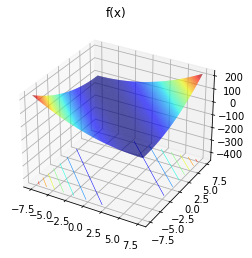

In [3]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 4
n_samples_estimation = int(1e6)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3).to("cuda")
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(17.0951, device='cuda:0')
tensor(17.1391, device='cuda:0')


In [6]:
epochs = 10000
batch_size = int(1e5)

# DReG, alpha=2

In [7]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

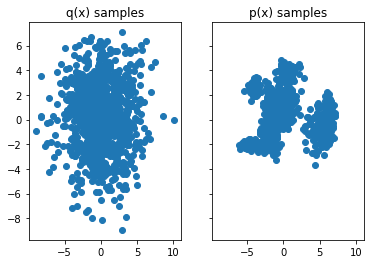

In [8]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [9]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

loss: -1.4886375453355756, mean log p_x -12.621706784856372: 100%|██████████| 10000/10000 [2:11:02<00:00,  1.27it/s] 


In [10]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 17.095077391494538 
estimate before training is 17.308963938306807 
estimate after training is 17.09285597310555 
effective sample size before is 0.006126271501124173
effective sample size after train is 0.2684909607185972
variance in weights is 2.7245229000433925e-12


In [11]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 17.095077391494538 
estimate before training is 17.308963938306807 
estimate after training is 17.08852455256359 
effective sample size before is 0.006126271501124173
effective sample size after train is 0.26850501957226236
variance in weights is 2.7243278849806417e-12


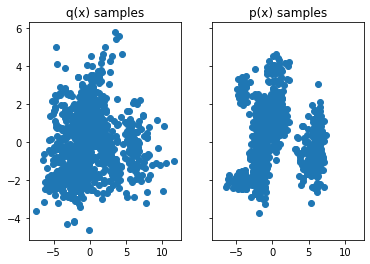

In [12]:
samples_fig_after = plot_samples(tester)

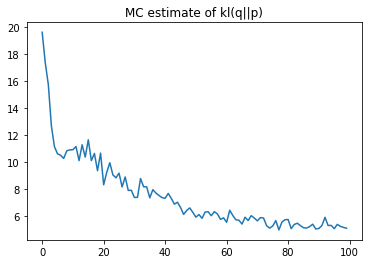

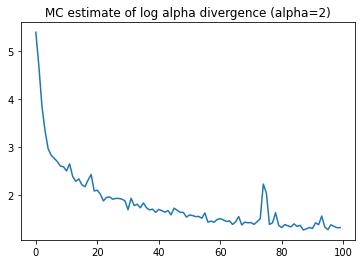

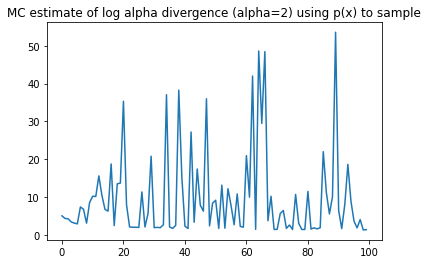

In [13]:
plot_divergences(history)

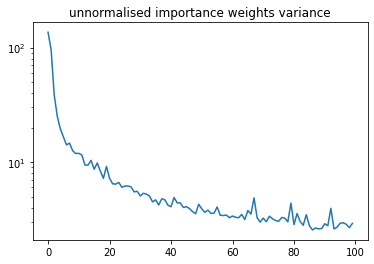

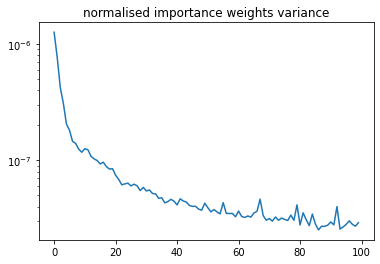

In [14]:
plot_sampling_info(history)

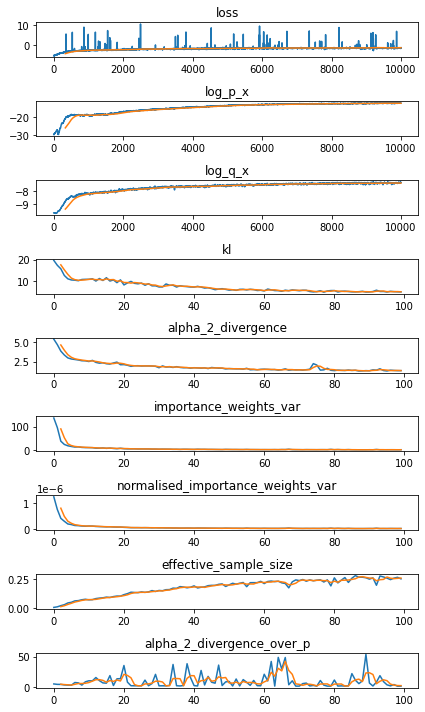

In [15]:
hist_plot = plot_history(history)

# KL

In [16]:
torch.manual_seed(1)
learnt_sampler_kl = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler_kl, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before_kl, info_before_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)

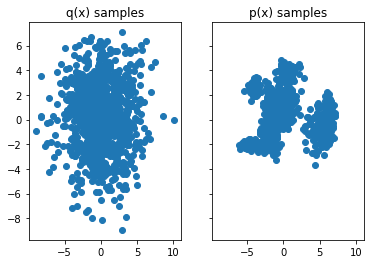

In [17]:
samples_fig_before = plot_samples(tester_kl)

In [18]:
history_kl = tester_kl.train(epochs, batch_size=batch_size,)

loss: 1.095344863838789, mean log p_x -6.461908323494135: 100%|██████████| 10000/10000 [38:27<00:00,  4.33it/s]  


In [19]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

True expectation estimate is 17.095077391494538 
estimate before training is 17.308963938306807 
estimate after training is 16.340221127906215 
effective sample size before is 0.006126271501124173
effective sample size after train is 0.0009068657321387343
variance in weights is 1.101700172313149e-09


In [20]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

True expectation estimate is 17.095077391494538 
estimate before training is 17.308963938306807 
estimate after training is 16.288946530227737 
effective sample size before is 0.006126271501124173
effective sample size after train is 0.0009044484664193966
variance in weights is 1.1046472936153286e-09


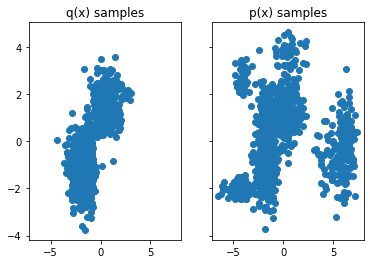

In [21]:
samples_fig_after = plot_samples(tester_kl)

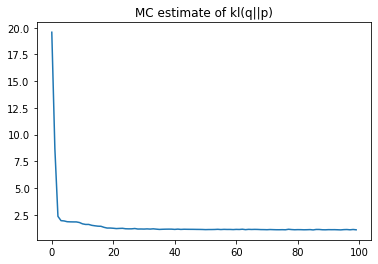

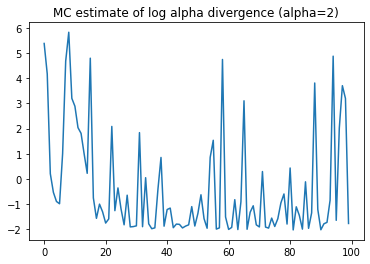

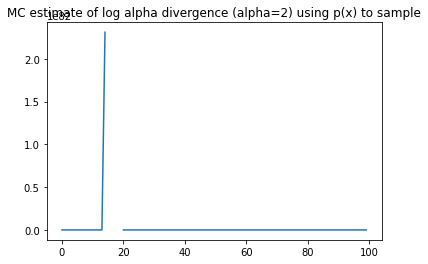

In [22]:
plot_divergences(history_kl)

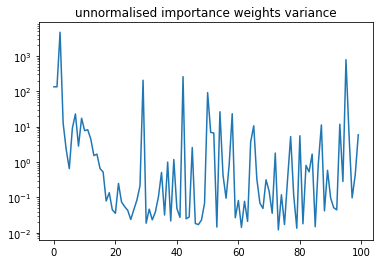

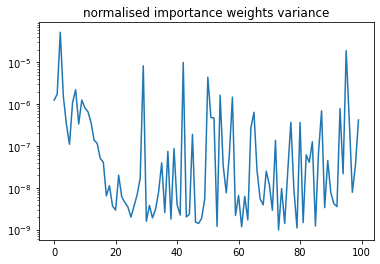

In [23]:
plot_sampling_info(history_kl)

NaN encountered in alpha_2_divergence_over_p history


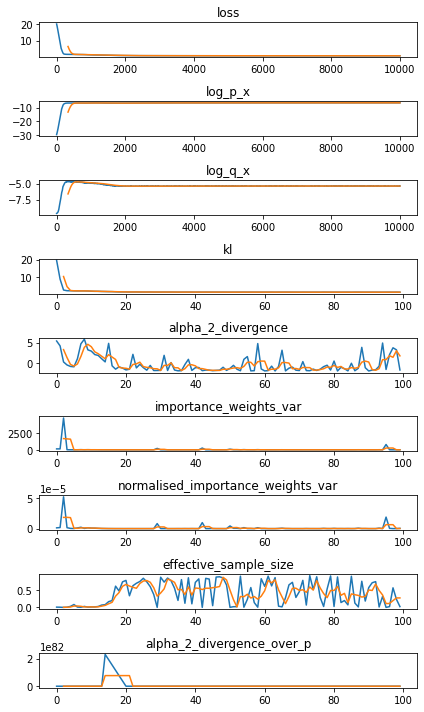

In [24]:
hist_plot = plot_history(history_kl)